### Ignore that part if you have the local dataset

This is to read the data from Google Cloud, but the bucket is private.

In [1]:
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "fiap-hacka"  # or a location like "my-bucket/path/to/mount"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}
!ls -lh {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   9378      0 --:--:-- --:--:-- --:--:--  9462
OK
40 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 14.8 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unsele

In [2]:
!pip install uv
!uv pip install torchvision opencv-python lxml pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 89.0 MB/s eta 0:00:00
Using Python 3.11.13 environment at: /usr
Resolved 40 packages in 480ms
⠙ Preparing packages... (0/10)
⠙ Preparing packages... (0/10)
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------     0 B/53.70 MiB
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------     0 B/53.70 MiB
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------     0 B/53.70 MiB
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------     0 B/53.70 MiB
nvidia-cusparse-cu12 ------------------------------     0 B/197.84 MiB
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------ 14.89 KiB/53.70 MiB
nvidia-cusparse-cu12 ------------------------------     0 B/197.84 MiB
⠙ Preparing packages... (0/10)
nvidia-curand-cu12   ------------------------------ 14.89 KiB/53.70 MiB
nvidia-cusparse-cu12 --------------

In [5]:
# Em um arquivo chamado dataset.py
import torch
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import List, Dict, Any, Tuple
from PIL import Image
import torchvision.transforms as T

class PascalVOCDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: Path, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Encontra todas as imagens e garante que elas tenham um XML correspondente
        self.image_paths = sorted([p for p in root_dir.glob("*.png") if (p.with_suffix(".xml")).exists()])

        # Cria um mapeamento de nome de classe para número inteiro
        # O modelo precisa de números, não de strings.
        # IMPORTANTE: A classe 0 é reservada para o 'background' (fundo)
        all_labels = self._find_all_unique_labels()
        self.class_to_int = {label: i + 1 for i, label in enumerate(all_labels)}
        self.int_to_class = {i: label for label, i in self.class_to_int.items()}

    def _find_all_unique_labels(self) -> List[str]:
        """Encontra todas as classes únicas no dataset para criar o mapeamento."""
        unique_labels = set()
        for img_path in self.image_paths:
            xml_path = img_path.with_suffix(".xml")
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for member in root.findall("object"):
                unique_labels.add(member.find("name").text)
        return sorted(list(unique_labels))

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, Any]]:
        image_path = self.image_paths[idx]
        xml_path = image_path.with_suffix(".xml")

        # Carrega a imagem
        image = Image.open(image_path).convert("RGB")

        # Parse do XML para obter as anotações
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for member in root.findall("object"):
            xmin = int(member.find("bndbox").find("xmin").text)
            ymin = int(member.find("bndbox").find("ymin").text)
            xmax = int(member.find("bndbox").find("xmax").text)
            ymax = int(member.find("bndbox").find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

            class_name = member.find("name").text
            labels.append(self.class_to_int[class_name])

        # Converte tudo para tensores do PyTorch
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Cria o dicionário de 'target' no formato que o torchvision espera
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

# Função para obter as transformações (converter para Tensor)
def get_transform():
    return T.Compose([T.ToTensor()])


In [6]:
# Em um arquivo chamado train.py

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pathlib import Path

def get_model(num_classes: int):
    # Carrega um modelo Faster R-CNN pré-treinado no COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Pega o número de features de entrada para o classificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Substitui a "cabeça" pré-treinada por uma nova
    # A nova cabeça terá o número de classes correto para o nosso problema
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [23]:
MODEL_NAME: str = 'architecture_model.pth'

In [10]:
# Continuação do train.py
from datetime import datetime
from tqdm.notebook import tqdm


def main():
    global MODEL_NAME
    # --- CONFIGURAÇÕES ---
    datetime_now = datetime.now().strftime("%Y%m%d_%H%M%S")
    DATASET_PATH: Path = Path("/mnt/gs/fiap-hacka/dataset_augment")
    NUM_EPOCHS = 10 # Número de vezes para treinar com o dataset inteiro
    MODEL_PATH: Path = Path(f"/mnt/gs/fiap-hacka/architecture_model_num_epochs_{NUM_EPOCHS}_dt_{datetime_now}.pth")
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # --- FIM DAS CONFIGURAÇÕES ---
    MODEL_NAME = MODEL_PATH.name

    print(f"Usando dispositivo: {DEVICE}")

    # 1. Criar o Dataset
    dataset = PascalVOCDataset(root_dir=DATASET_PATH, transforms=get_transform())

    # IMPORTANTE: O número de classes é o número de rótulos únicos + 1 (para o fundo)
    num_classes = len(dataset.class_to_int) + 1

    # Dividir o dataset em treino e validação (80/20)
    indices = torch.randperm(len(dataset)).tolist()
    train_size = int(0.8 * len(dataset))
    dataset_train = torch.utils.data.Subset(dataset, indices[:train_size])
    dataset_val = torch.utils.data.Subset(dataset, indices[train_size:])

    # 2. Criar os DataLoaders
    # collate_fn é necessário para lidar com imagens de tamanhos diferentes em um batch
    def collate_fn(batch):
        return tuple(zip(*batch))

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
    )

    # 3. Carregar e adaptar o modelo
    model = get_model(num_classes)
    model.to(DEVICE)

    # 4. Definir o otimizador e o scheduler (opcional, mas recomendado)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # 5. Loop de Treinamento
    for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
        print(f"Iniciando época {epoch+1}/{NUM_EPOCHS}")
        model.train() # Coloca o modelo em modo de treino

        print("Treinando...")
        total_loss = 0
        for images, targets in tqdm(data_loader_train, desc="Batches"):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            # O modelo retorna um dicionário de perdas (losses)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        avg_loss = total_loss / len(data_loader_train)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss de Treino: {avg_loss:.4f}")

        # Atualiza o learning rate
        lr_scheduler.step()

    # 6. Salvar o modelo treinado
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Treinamento concluído! Modelo salvo como '{MODEL_PATH}'")

if __name__ == "__main__":
    main()

Usando dispositivo: cuda
Iniciando época 1/10
Treinando...
Epoch 1/10, Loss de Treino: 1.3524
Iniciando época 2/10
Treinando...
Epoch 2/10, Loss de Treino: 0.5247
Iniciando época 3/10
Treinando...
Epoch 3/10, Loss de Treino: 0.3447
Iniciando época 4/10
Treinando...
Epoch 4/10, Loss de Treino: 0.1870
Iniciando época 5/10
Treinando...
Epoch 5/10, Loss de Treino: 0.1560
Iniciando época 6/10
Treinando...
Epoch 6/10, Loss de Treino: 0.1443
Iniciando época 7/10
Treinando...
Epoch 7/10, Loss de Treino: 0.1324
Iniciando época 8/10
Treinando...
Epoch 8/10, Loss de Treino: 0.1312
Iniciando época 9/10
Treinando...
Epoch 9/10, Loss de Treino: 0.1309
Iniciando época 10/10
Treinando...
Epoch 10/10, Loss de Treino: 0.1299
Treinamento concluído! Modelo salvo como '/mnt/gs/fiap-hacka/architecture_model.pth'


Carregando mapeamento de classes...
Carregando modelo de '/mnt/gs/fiap-hacka/architecture_model.pth'...
Fazendo previsão na imagem '/content/test.png'...
Encontradas 7 anotações. Desenhando na imagem...
✅ Imagem com as previsões salva em: prediction_20250619_214914.png
✅ Saída JSON salva em: prediction_20250619_214914.json


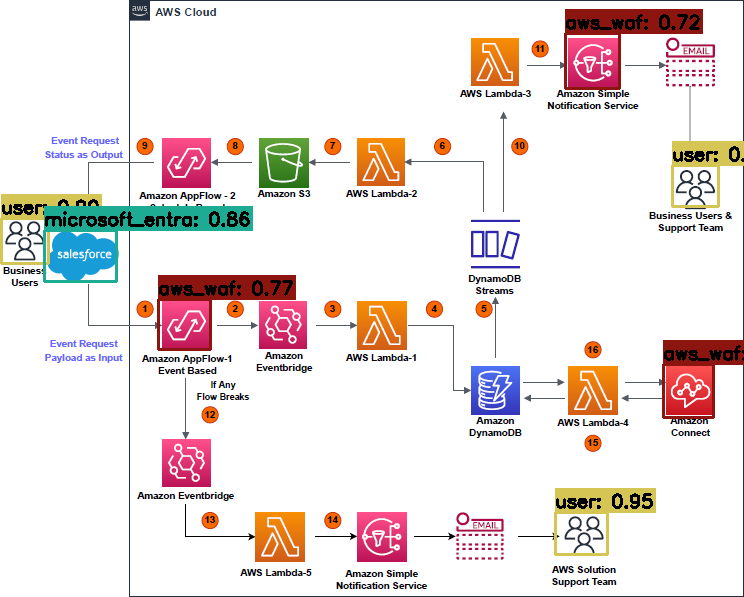

In [30]:
import torch
import torchvision
import cv2
import json
from PIL import Image
from pathlib import Path
from typing import List, Tuple
import random
from time import sleep
from google.colab.patches import cv2_imshow
from datetime import datetime

def make_prediction(
    model: torch.nn.Module,
    image_path: Path,
    device: torch.device,
    confidence_threshold: float = 0.7
) -> Tuple[List, List, List, int, int]: # <--- MUDANÇA: Agora retorna as dimensões da imagem
    """
    Faz uma previsão em uma única imagem.
    Retorna caixas, rótulos, pontuações e as dimensões da imagem original.
    """
    image = Image.open(image_path).convert("RGB")
    image_width, image_height = image.size # <--- NOVO: Captura as dimensões

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    image_tensor = transform(image).to(device)

    model.eval()

    with torch.no_grad():
        prediction = model([image_tensor])

    pred_scores = prediction[0]['scores'].detach().cpu().numpy()
    pred_boxes = prediction[0]['boxes'].detach().cpu().numpy()[pred_scores >= confidence_threshold]
    pred_labels = prediction[0]['labels'].detach().cpu().numpy()[pred_scores >= confidence_threshold]
    pred_scores = pred_scores[pred_scores >= confidence_threshold]

    # <--- MUDANÇA: Retorna as dimensões junto com as previsões
    return pred_boxes, pred_labels, pred_scores, image_width, image_height

def draw_boxes_on_image(
    image_path: Path,
    boxes: List,
    labels: List,
    scores: List,
    class_map: dict,
    output_path: Path
):
    """Desenha as caixas delimitadoras e os rótulos na imagem."""
    # Carrega a imagem usando OpenCV para podermos desenhar nela
    image = cv2.imread(str(image_path))

    # Gera uma cor aleatória para cada classe para melhor visualização
    colors = {}
    for label_int in class_map.keys():
        colors[label_int] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = map(int, box)
        label_int = labels[i]
        class_name = class_map.get(label_int, "Desconhecido")
        score = scores[i]
        color = colors.get(label_int, (255, 255, 255))

        # Desenha o retângulo
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        # Prepara o texto do rótulo
        text = f"{class_name}: {score:.2f}"

        # Desenha um fundo para o texto para melhor legibilidade
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(image, (xmin, ymin - text_height - 10), (xmin + text_width, ymin), color, -1)

        # Escreve o texto
        cv2.putText(
            image,
            text,
            (xmin, ymin - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 0, 0), # Cor do texto preta
            2
        )

    # Salva a imagem com as anotações
    cv2.imwrite(str(output_path), image)
    print(f"✅ Imagem com as previsões salva em: {output_path}")

def format_predictions_as_json(
    boxes: List,
    labels: List,
    scores: List,
    class_map: Dict[int, str],
    image_width: int,
    image_height: int,
    model_path: Path
) -> Dict[str, Any]:
    """
    Formata as previsões do PyTorch em um dicionário que imita a saída do AutoML.
    """
    predictions_list = []
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box

        # Normaliza as coordenadas para o formato 0.0-1.0
        normalized_box = {
            "xMin": float(xmin / image_width),
            "yMin": float(ymin / image_height),
            "xMax": float(xmax / image_width),
            "yMax": float(ymax / image_height),
        }

        prediction_item = {
            "confidence": float(scores[i]),
            "displayName": class_map.get(labels[i], "Desconhecido"),
            "boundingBox": normalized_box
        }
        predictions_list.append(prediction_item)

    # Cria o objeto final, similar ao do AutoML
    final_output = {
        "predictions": predictions_list,
        "modelInfo": {
            "type": "local_pytorch",
            "model_path": str(model_path)
        }
    }
    return final_output

def main():
    global MODEL_NAME
    # --- CONFIGURAÇÕES ---

    BASE_PATH = Path("/mnt/gs/fiap-hacka/") # Precisamos disso para pegar o mapa de classes
    MODEL_PATH = BASE_PATH / MODEL_NAME
    DATASET_PATH = BASE_PATH / "dataset_augment"

    datetime_now = datetime.now().strftime("%Y%m%d_%H%M%S")
    IMAGE_TO_TEST = Path("/content/test.png") #
    OUTPUT_IMAGE_PATH = Path(f"prediction_{datetime_now}.png")
    OUTPUT_JSON_PATH = Path(f"prediction_{datetime_now}.json")

    CONFIDENCE = 0.7 # Limiar de confiança (só mostra previsões acima de 70%)
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # --- FIM DAS CONFIGURAÇÕES ---

    if not IMAGE_TO_TEST.exists():
        print(f"❌ Erro: A imagem de teste '{IMAGE_TO_TEST}' não foi encontrada.")
        print("Por favor, atualize a variável 'IMAGE_TO_TEST' no script.")
        return

    # 1. Recriar o dataset APENAS para obter o mapeamento de classes
    #    Isso garante que os números correspondem aos rótulos corretos.
    print("Carregando mapeamento de classes...")
    temp_dataset = PascalVOCDataset(root_dir=DATASET_PATH)
    num_classes = len(temp_dataset.class_to_int) + 1
    class_map = temp_dataset.int_to_class

    # 2. Carregar o modelo treinado
    print(f"Carregando modelo de '{MODEL_PATH}'...")
    model = get_model(num_classes)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)

    # 3. Fazer a previsão
    print(f"Fazendo previsão na imagem '{IMAGE_TO_TEST}'...")
    boxes, labels, scores, img_width, img_height = make_prediction(model, IMAGE_TO_TEST, DEVICE, CONFIDENCE)

    # 4. Desenhar os resultados na imagem
    print(f"Encontradas {len(boxes)} anotações. Desenhando na imagem...")
    draw_boxes_on_image(IMAGE_TO_TEST, boxes, labels, scores, class_map, OUTPUT_IMAGE_PATH)

    json_output = format_predictions_as_json(boxes, labels, scores, class_map, img_width, img_height, MODEL_PATH)
    with open(OUTPUT_JSON_PATH, "w", encoding="utf-8") as f:
        json.dump(json_output, f, ensure_ascii=False, indent=4)
    print(f"✅ Saída JSON salva em: {OUTPUT_JSON_PATH}")
    # --- FIM DA LÓGICA NOVA ---

    # Opcional: se você estiver em um ambiente com GUI, pode mostrar a imagem
    result_image = cv2.imread(str(OUTPUT_IMAGE_PATH))
    cv2_imshow(result_image)
    sleep(15)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()